# Predicting House Sale Prices

## Introduction

In this guided project, we can practice what we learned in this course by exploring ways to improve the models we built.

In this course, we started by building intuition for model based learning, explored how the linear regression model worked, understood how the two different approaches to model fitting worked, and some techniques for cleaning, transforming, and selecting features.

You'll work with housing data for the city of Ames, Iowa, United States from 2006 to 2010. You can read more about why the data was collected [here](https://doi.org/10.1080/10691898.2011.11889627). You can also read about the different columns in the data [here](https://s3.amazonaws.com/dq-content/307/data_description.txt).

## Importing packages and reading dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

%matplotlib inline
pd.options.display.max_columns = 999

In [2]:
data = pd.read_csv("my_datasets/AmesHousing.tsv", delimiter="\t")
print("Dataset size:",data.shape)

Dataset size: (2930, 82)


In [3]:
data.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


## Initial functions definition

In [4]:
def transform_features(df):
    return df

In [5]:
def select_features(df):
    features = ["Gr Liv Area","SalePrice"]
    return df[features]

In [6]:
def train_and_test(df):
    train = df[:1460]
    test = df[1460:]
    
    selected_cols = select_features(train).columns
    target_col = "SalePrice"
    features_col = selected_cols.drop(target_col)
    
    train_target = train[target_col]
    train_features = train[features_col]
    
    lr = LinearRegression()
    lr.fit(train_features,train_target)
    predictions = lr.predict(test[features_col])
    
    mse = mean_squared_error(predictions, test[target_col])
    rmse = np.sqrt(mse)
    
    return rmse

## Feature Engineering

Let's now start to removing features with many missing values, diving deeper into potential categorical features, and transforming text and numerical columns.

Update **transform_features()** so that any column from the data frame with more than 5% (or another cutoff value) missing values is dropped. We also need to remove any columns that leak information about the sale (e.g. like the year the sale happened). In general, the goal of this function is to:
- remove features that we don't want to use in the model, just based on the number of missing values or data leakage
- transform features into the proper format (numerical to categorical, scaling numerical, filling in missing values, etc)
- create new features by combining other features

Let's start removing columns with more than 5% missing values (apply to **all columns**)

In [7]:
missing_values = data.isnull().sum()
drop_columns = missing_values[missing_values > len(data)/20].index
print(drop_columns)

Index(['Lot Frontage', 'Alley', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'Garage Finish', 'Garage Qual', 'Garage Cond', 'Pool QC', 'Fence',
       'Misc Feature'],
      dtype='object')


In [8]:
data = data.drop(drop_columns, axis=1)

Let's drop columns with 1 or more missing values (apply to **text columns**):

In [9]:
text_columns = data.select_dtypes(include=["object"]).columns
missing_values_text = data[text_columns].isnull().sum()
drop_columns_text = missing_values_text[missing_values_text>0].index
print(drop_columns_text)

Index(['Mas Vnr Type', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin Type 2', 'Electrical'],
      dtype='object')


In [10]:
data = data.drop(drop_columns_text, axis=1)

If missing values are below 5%, fill them with the most popular values (apply to **numerical columns**):

In [11]:
numeric_columns = data.select_dtypes(include=["int64","float"]).columns
data[numeric_columns].isnull().sum()

Order               0
PID                 0
MS SubClass         0
Lot Area            0
Overall Qual        0
Overall Cond        0
Year Built          0
Year Remod/Add      0
Mas Vnr Area       23
BsmtFin SF 1        1
BsmtFin SF 2        1
Bsmt Unf SF         1
Total Bsmt SF       1
1st Flr SF          0
2nd Flr SF          0
Low Qual Fin SF     0
Gr Liv Area         0
Bsmt Full Bath      2
Bsmt Half Bath      2
Full Bath           0
Half Bath           0
Bedroom AbvGr       0
Kitchen AbvGr       0
TotRms AbvGrd       0
Fireplaces          0
Garage Cars         1
Garage Area         1
Wood Deck SF        0
Open Porch SF       0
Enclosed Porch      0
3Ssn Porch          0
Screen Porch        0
Pool Area           0
Misc Val            0
Mo Sold             0
Yr Sold             0
SalePrice           0
dtype: int64

In [12]:
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mode().iloc[0])
data[numeric_columns].isnull().sum()

Order              0
PID                0
MS SubClass        0
Lot Area           0
Overall Qual       0
Overall Cond       0
Year Built         0
Year Remod/Add     0
Mas Vnr Area       0
BsmtFin SF 1       0
BsmtFin SF 2       0
Bsmt Unf SF        0
Total Bsmt SF      0
1st Flr SF         0
2nd Flr SF         0
Low Qual Fin SF    0
Gr Liv Area        0
Bsmt Full Bath     0
Bsmt Half Bath     0
Full Bath          0
Half Bath          0
Bedroom AbvGr      0
Kitchen AbvGr      0
TotRms AbvGrd      0
Fireplaces         0
Garage Cars        0
Garage Area        0
Wood Deck SF       0
Open Porch SF      0
Enclosed Porch     0
3Ssn Porch         0
Screen Porch       0
Pool Area          0
Misc Val           0
Mo Sold            0
Yr Sold            0
SalePrice          0
dtype: int64

Let's check the remaining missing values:

In [13]:
data.isnull().sum().value_counts()

0    64
dtype: int64

There are no missing values in the dataframe.

What new features can we create, that better capture the information in some of the features?

In [14]:
years_sold = data['Yr Sold'] - data['Year Built']
years_sold[years_sold < 0]

2180   -1
dtype: int64

In [15]:
years_since_remod = data['Yr Sold'] - data['Year Remod/Add']
years_since_remod[years_since_remod < 0]

1702   -1
2180   -2
2181   -1
dtype: int64

In [16]:
## Create new columns
data['Years Before Sale'] = years_sold
data['Years Since Remod'] = years_since_remod

## Drop rows with negative values for both of these new features
data = data.drop([1702, 2180, 2181], axis=0)

## No longer need original year columns
data = data.drop(["Year Built", "Year Remod/Add", "Yr Sold"], axis = 1)

Drop columns that:
- that aren't useful for ML
- leak data about the final sale, read more about columns [here](https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt)

In [17]:
## Drop columns that aren't useful for ML
data = data.drop(["PID", "Order"], axis=1)

## Drop columns that leak info about the final sale
data = data.drop(["Mo Sold", "Sale Condition", "Sale Type"], axis=1)

Let's update transform_features() function. It should perform all the steps from this section:

In [18]:
def transform_features(df):
    num_missing = df.isnull().sum()
    drop_missing_cols = num_missing[(num_missing > len(df)/20)]
    df = df.drop(drop_missing_cols.index, axis=1)
    
    text_mv_counts = df.select_dtypes(include=['object']).isnull().sum()
    drop_missing_cols_2 = text_mv_counts[text_mv_counts > 0]
    df = df.drop(drop_missing_cols_2.index, axis=1)
    
    numeric_columns = data.select_dtypes(include=["int64","float64"]).columns
    df[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mode().iloc[0])
    
    df['Years Before Sale'] = df['Yr Sold'] - df['Year Built']
    df['Years Since Remod'] = df['Yr Sold'] - df['Year Remod/Add']
    df = df.drop(df[df['Years Before Sale']<0].index, axis=0)
    df = df.drop(df[df['Years Since Remod']<0].index, axis=0)

    df = df.drop(["PID", "Order", "Mo Sold", "Sale Condition", "Sale Type", "Year Built", "Year Remod/Add", "Yr Sold"], axis=1)
    return df

In [19]:
data = pd.read_csv("my_datasets/AmesHousing.tsv", delimiter="\t")
transform_data = transform_features(data)
filtered_data = select_features(transform_data)
rmse = train_and_test(filtered_data)

rmse

55275.367312413066

## Feature Selection

Now that we have cleaned and transformed a lot of the features in the data set, it's time to move on to feature selection for numerical features.

In [20]:
numeric_values = transform_data.select_dtypes(include=["int64","float64"])
numeric_values.head()

,MS SubClass,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice,Lot Frontage,Garage Yr Blt,Years Before Sale,Years Since Remod
0,20,31770,6,5,112.0,639.0,0.0,441.0,1080.0,1656,0,0,1656,1.0,0.0,1,0,3,1,7,2,2.0,528.0,210,62,0,0,0,0,0,215000,141.0,1960.0,50,50
1,20,11622,5,6,0.0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1.0,730.0,140,0,0,0,120,0,0,105000,80.0,1961.0,49,49
2,20,14267,6,6,108.0,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,3,1,6,0,1.0,312.0,393,36,0,0,0,0,12500,172000,81.0,1958.0,52,52
3,20,11160,7,5,0.0,1065.0,0.0,1045.0,2110.0,2110,0,0,2110,1.0,0.0,2,1,3,1,8,2,2.0,522.0,0,0,0,0,0,0,0,244000,93.0,1968.0,42,42
4,60,13830,5,5,0.0,791.0,0.0,137.0,928.0,928,701,0,1629,0.0,0.0,2,1,3,1,6,1,2.0,482.0,212,34,0,0,0,0,0,189900,74.0,1997.0,13,12


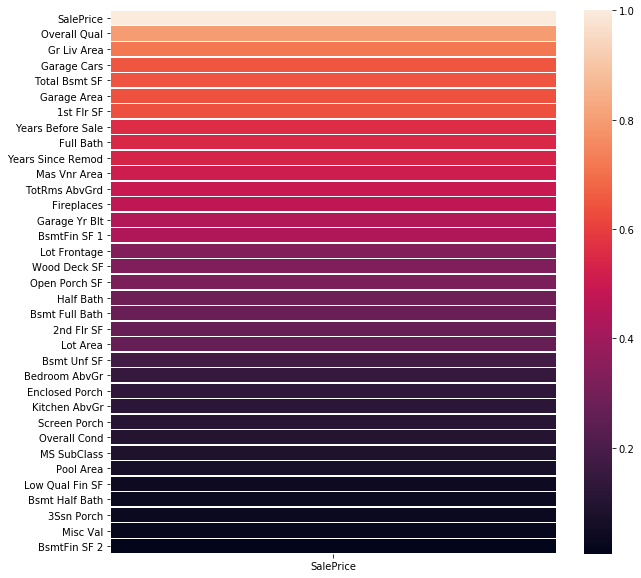

In [21]:
features_correlation = numeric_values.corr().abs()[["SalePrice"]]
sorted_features_corr = features_correlation.sort_values(by="SalePrice", ascending=False)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(sorted_features_corr, linewidths=.5, ax=ax)

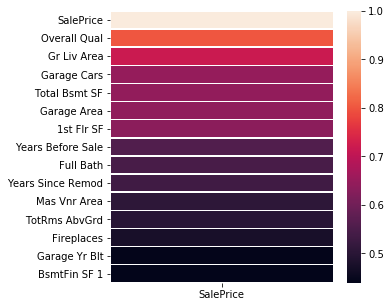

In [22]:
## Let's only keep columns with a correlation coefficient of larger than 0.4 (arbitrary)
relevant_features_corr = sorted_features_corr[sorted_features_corr["SalePrice"] > 0.4]

fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(relevant_features_corr, linewidths=.5, ax=ax)

Let's drop the non-relevant numeric columns:

In [23]:
non_rel_cols = numeric_values.columns.drop(relevant_features_corr.index)
non_rel_cols

Index(['MS SubClass', 'Lot Area', 'Overall Cond', 'BsmtFin SF 2',
       'Bsmt Unf SF', '2nd Flr SF', 'Low Qual Fin SF', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr',
       'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch',
       'Screen Porch', 'Pool Area', 'Misc Val', 'Lot Frontage'],
      dtype='object')

In [24]:
transform_data = transform_data.drop(non_rel_cols, axis=1)

Which categorical columns should we keep?

In [25]:
# Create a list of column names from documentation that are *meant* to be categorical
nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

- Which columns are currently numerical but need to be encoded as categorical instead (because the numbers don't have any semantic meaning)?
- If a categorical column has hundreds of unique values (or categories), should we keep it? When we dummy code this column, hundreds of columns will need to be added back to the data frame.

In [26]:
## Which categorical columns have we still carried with us?
transform_cat_cols = [col for col in nominal_features if col in transform_data.columns]
transform_cat_cols

['MS Zoning',
 'Street',
 'Land Contour',
 'Lot Config',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Foundation',
 'Heating',
 'Central Air']

In [27]:
## How many unique values in each categorical column?
uniqueness_counts = transform_data[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()

## Aribtrary cutoff of 10 unique values
drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
transform_data = transform_data.drop(drop_nonuniq_cols, axis=1)

In [28]:
## Select just the remaining text columns and convert to categorical
text_cols = transform_data.select_dtypes(include=['object']).columns
for col in text_cols:
    transform_data[col] = transform_data[col].astype('category')
    
## Create dummy columns and add back to the dataframe!
transform_data = pd.concat([
    transform_data, 
    pd.get_dummies(transform_data.select_dtypes(include=['category']))
], axis=1).drop(text_cols,axis=1)

transform_data.head()

,Overall Qual,Mas Vnr Area,BsmtFin SF 1,Total Bsmt SF,1st Flr SF,Gr Liv Area,Full Bath,TotRms AbvGrd,Fireplaces,Garage Cars,Garage Area,SalePrice,Garage Yr Blt,Years Before Sale,Years Since Remod,MS Zoning_A (agr),MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Street_Grvl,Street_Pave,Lot Shape_IR1,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,Land Contour_Bnk,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Utilities_AllPub,Utilities_NoSeWa,Utilities_NoSewr,Lot Config_Corner,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Land Slope_Gtl,Land Slope_Mod,Land Slope_Sev,Condition 1_Artery,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Artery,Condition 2_Feedr,Condition 2_Norm,Condition 2_PosA,Condition 2_PosN,Condition 2_RRAe,Condition 2_RRAn,Condition 2_RRNn,Bldg Type_1Fam,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,House Style_1.5Fin,House Style_1.5Unf,House Style_1Story,House Style_2.5Fin,House Style_2.5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Roof Style_Flat,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,Roof Style_Shed,Roof Matl_ClyTile,Roof Matl_CompShg,Roof Matl_Membran,Roof Matl_Metal,Roof Matl_Roll,Roof Matl_Tar&Grv,Roof Matl_WdShake,Roof Matl_WdShngl,Exter Qual_Ex,Exter Qual_Fa,Exter Qual_Gd,Exter Qual_TA,Exter Cond_Ex,Exter Cond_Fa,Exter Cond_Gd,Exter Cond_Po,Exter Cond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Heating QC_Ex,Heating QC_Fa,Heating QC_Gd,Heating QC_Po,Heating QC_TA,Central Air_N,Central Air_Y,Kitchen Qual_Ex,Kitchen Qual_Fa,Kitchen Qual_Gd,Kitchen Qual_Po,Kitchen Qual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Sev,Functional_Typ,Paved Drive_N,Paved Drive_P,Paved Drive_Y
0,6,112.0,639.0,1080.0,1656,1656,1,7,2,2.0,528.0,215000,1960.0,50,50,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
1,5,0.0,468.0,882.0,896,896,1,5,0,1.0,730.0,105000,1961.0,49,49,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
2,6,108.0,923.0,1329.0,1329,1329,1,6,0,1.0,312.0,172000,1958.0,52,52,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
3,7,0.0,1065.0,2110.0,2110,2110,2,8,2,2.0,522.0,244000,1968.0,42,42,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
4,5,0.0,791.0,928.0,928,1629,2,6,1,2.0,482.0,189900,1997.0,13,12,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1


Let's update the select_features() function:

In [29]:
def select_features(df, coeff_threshold=0.4, uniq_threshold=10):
    numerical_df = df.select_dtypes(include=['int64', 'float64'])
    abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values()
    df = df.drop(abs_corr_coeffs[abs_corr_coeffs < coeff_threshold].index, axis=1)
    
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    
    transform_cat_cols = [col for col in nominal_features if col in df.columns]
    uniqueness_counts = df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
    drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > uniq_threshold].index
    df = df.drop(drop_nonuniq_cols, axis=1)
    
    text_cols = df.select_dtypes(include=['object']).columns
    for col in text_cols:
        df[col] = df[col].astype('category')
    df = pd.concat([df, pd.get_dummies(df.select_dtypes(include=['category']))], axis=1).drop(text_cols,axis=1)
    
    return df

## Train and Test

Now for the final part of the pipeline, training and testing. When iterating on different features, using simple validation is a good idea. Let's add a parameter named **k** that controls the type of cross validation that occurs:
- When k equals 0 (default value), perform holdout validation (what we already implemented):
    - Select the first 1460 rows and assign to train.
    - Select the remaining rows and assign to test.
    - Train on train and test on test.
    - Compute the RMSE and return.
- When k equals 1, perform simple cross validation:
    - Shuffle the ordering of the rows in the data frame.
    - Select the first 1460 rows and assign to fold_one.
    - Select the remaining rows and assign to fold_two.
    - Train on fold_one and test on fold_two.
    - Train on fold_two and test on fold_one.
    - Compute the average RMSE and return.
- When k is greater than 1, implement k-fold cross validation using k folds:
    - Perform k-fold cross validation using k folds.
    - Calculate the average RMSE value and return this value.

In [30]:
def train_and_test(df, k=0):
    numeric_df = df.select_dtypes(include=['int64', 'float64'])
    features = numeric_df.columns.drop("SalePrice")
    lr = LinearRegression()
    
    if k == 0:
        train = df[:1460]
        test = df[1460:]

        lr.fit(train[features], train["SalePrice"])
        predictions = lr.predict(test[features])
        mse = mean_squared_error(test["SalePrice"], predictions)
        rmse = np.sqrt(mse)

        return rmse
    
    if k == 1:
        # Randomize *all* rows (frac=1) from `df` and return
        shuffled_df = df.sample(frac=1)
        train = df[:1460]
        test = df[1460:]
        
        lr.fit(train[features], train["SalePrice"])
        predictions_one = lr.predict(test[features])        
        
        mse_one = mean_squared_error(test["SalePrice"], predictions_one)
        rmse_one = np.sqrt(mse_one)
        
        lr.fit(test[features], test["SalePrice"])
        predictions_two = lr.predict(train[features])        
       
        mse_two = mean_squared_error(train["SalePrice"], predictions_two)
        rmse_two = np.sqrt(mse_two)
        
        avg_rmse = np.mean([rmse_one, rmse_two])
        #print(rmse_one)
        #print(rmse_two)
        return avg_rmse
    else:
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values = []
        for train_index, test_index, in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr.fit(train[features], train["SalePrice"])
            predictions = lr.predict(test[features])
            mse = mean_squared_error(test["SalePrice"], predictions)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
        #print(rmse_values)
        avg_rmse = np.mean(rmse_values)
        return avg_rmse

## Checking the final state

In [31]:
data = pd.read_csv("my_datasets/AmesHousing.tsv", delimiter="\t")
transform_data = transform_features(data)
filtered_data = select_features(transform_data)

rmse1 = train_and_test(filtered_data)
rmse2 = train_and_test(filtered_data, k=1)
rmse3 = train_and_test(filtered_data, k=4)

print("RMSE using k=0:", rmse1)
print("RMSE using k=1:", rmse2)
print("RMSE using k=4:", rmse3)

RMSE using k=0: 36571.09404570379
RMSE using k=1: 33727.04285056963
RMSE using k=4: 32958.483524080686
